In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from load_data import *
from flow_catlog import *
import flow_manager as fm
import autoencoder as ae
import classifier as clfr
from sampler import *
from utl import *
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tensorflow.compat.v1 import logging
import math
logging.set_verbosity(logging.ERROR)

In [2]:
DTYPE=tf.float32
NP_DTYPE=np.float32
num_bijectors = 10
steps = 5000
lr =1e-4
datafile = 'X_train.csv'

In [3]:
X_data = pd.read_csv(datafile, header=None)
X_data = X_data.iloc[:10000]

X_data = X_data.values.astype(NP_DTYPE)
X_data = StandardScaler().fit_transform(X_data)
input_dims = X_data.shape[1]

In [4]:
X_train, X_test = train_test_split(X_data, test_size=0.33, random_state=42, shuffle=False)

In [5]:
def local_ploter(data, cols=4):
    nrows = math.ceil(data.shape[1]/cols)
    fig, ax = plt.subplots(nrows=nrows, ncols=cols, figsize=(30,10))
    for i in range(math.ceil(data.shape[1]/cols)):
        for j in range(cols):
            if i*cols+j < data.shape[1]:
                if nrows == 1:
                    ax[j].plot(data[:, i*cols+j])
                    # ax[j].set_ylim(0, 1)
                else:
                    ax[i][j].plot(data[:, i*cols+j])
                    # ax[i][j].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

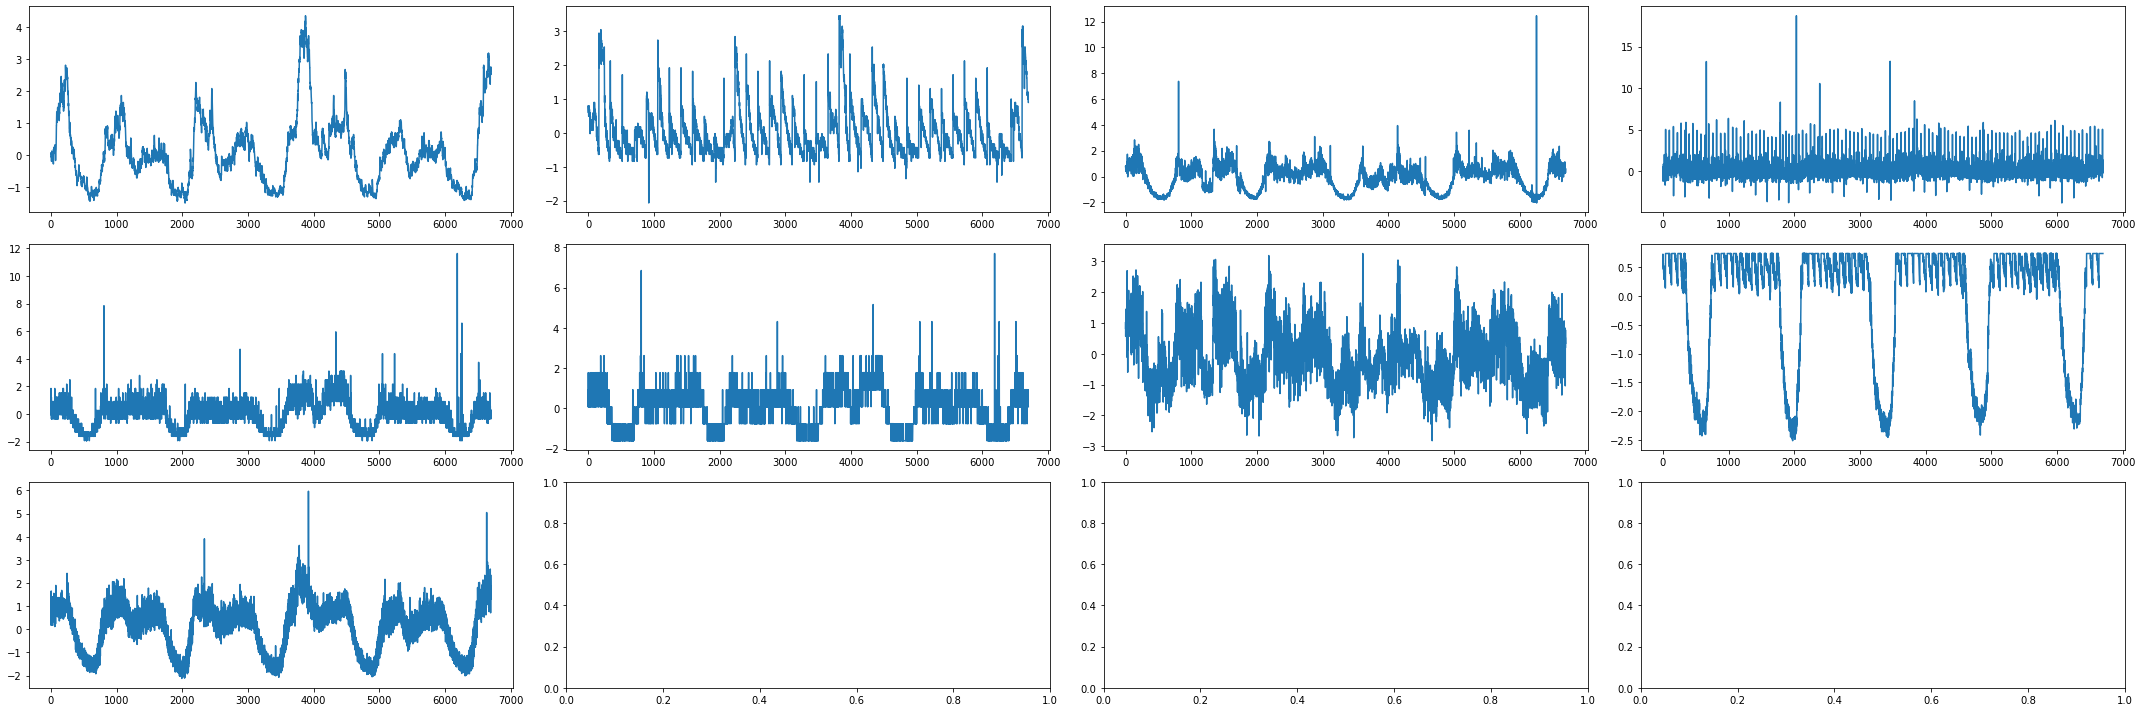

In [6]:
local_ploter(X_train)

# Train an AutoEncoder

In [7]:
%%script false --no-raise-error

# Parameters for AutoEncoder
latent_dims = 2
encoder_units = [64, 32]
decoder_units = [32, 64]

encoder = ae.build_encoder(input_dims, latent_dims, hidden_units=encoder_units)
decoder = ae.build_decoder(input_dims, latent_dims, hidden_units=decoder_units)
autoencoder = ae.AutoEncoder(encoder, decoder, flow_model=None, flow_opt=None)
autoencoder.compile()
history = autoencoder.fit(X_train, epochs=30, batch_size=64, verbose=1, validation_split=0.33, shuffle=True)
plt.plot(history.history['reconstruction_loss'])

X_train_decoded = autoencoder.predict(X_train)
local_ploter(X_train_decoded)

In [8]:
# local_ploter(autoencoder.encoder.predict(X_train))

In [9]:
# X_train = autoencoder.predict(X_train)
# input_dims = X_train.shape[1]

# Smooth Data

In [10]:
%%script false --no-raise-error

# import libraries
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.utils_func import sim_seasonal_data
from tsmoothie.smoother import ConvolutionSmoother
from tsmoothie.bootstrap import BootstrappingWrapper

# operate bootstrap
bts = BootstrappingWrapper(ConvolutionSmoother(window_len=8, window_type='ones'), 
                           bootstrap_type='mbb', block_length=24)
bts_samples = bts.sample(X_train[:, 0], n_samples=100)

# plot the bootstrapped timeseries
plt.figure(figsize=(13,5))
plt.plot(bts_samples.T, alpha=0.3, c='orange')
plt.plot(X_train[:, 0], c='blue', linewidth=0.5)

# Training a Flow Model

In [11]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([input_dims], DTYPE), scale_diag=tf.ones([input_dims], tf.float32))

steps: 0 	 loss: 15.199283
steps: 100 	 loss: 6.009343
steps: 200 	 loss: 5.4978967
steps: 300 	 loss: 4.988011
steps: 400 	 loss: 4.700477
steps: 500 	 loss: 4.4220643
steps: 600 	 loss: 4.2782516
steps: 700 	 loss: 4.2133126
steps: 800 	 loss: 4.075233
steps: 900 	 loss: 3.9416
steps: 1000 	 loss: 3.8060212
steps: 1100 	 loss: 3.706318
steps: 1200 	 loss: 3.8787951
steps: 1300 	 loss: 3.6181822
steps: 1400 	 loss: 3.6452653
steps: 1500 	 loss: 3.6363273
steps: 1600 	 loss: 3.4334602
steps: 1700 	 loss: 3.4792237
steps: 1800 	 loss: 3.2461069
steps: 1900 	 loss: 3.3756645


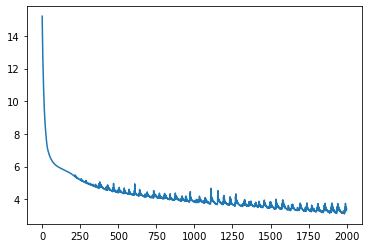

In [12]:
model = MAF(base_dist, 
            num_bijectors, 
            hidden_units=[32, 32],
            ndims=input_dims,
            activation=tf.nn.tanh,
            learning_rate=lr, 
            use_batchnorm=True)
losses = fm.train_dist_routine(X_train, model.flow, lr, steps)
plt.plot(losses)

# _ = model(X_train)
# model.compile()
# history = model.fit(x=X_train, batch_size=128, epochs=30, shuffle=True)

In [13]:
# model = RealNVP(input_shape=input_dims, num_coupling_layers=num_bijectors)
# model.compile(optimizer=tfk.optimizers.Adam(learning_rate=lr))
# history = model.fit(
#     X_train, batch_size=256, epochs=100, verbose=2, validation_split=0.2
# )

In [14]:
X_train_samples = base_dist.sample(1000)
X_train_samples = model.predict(X_train_samples)

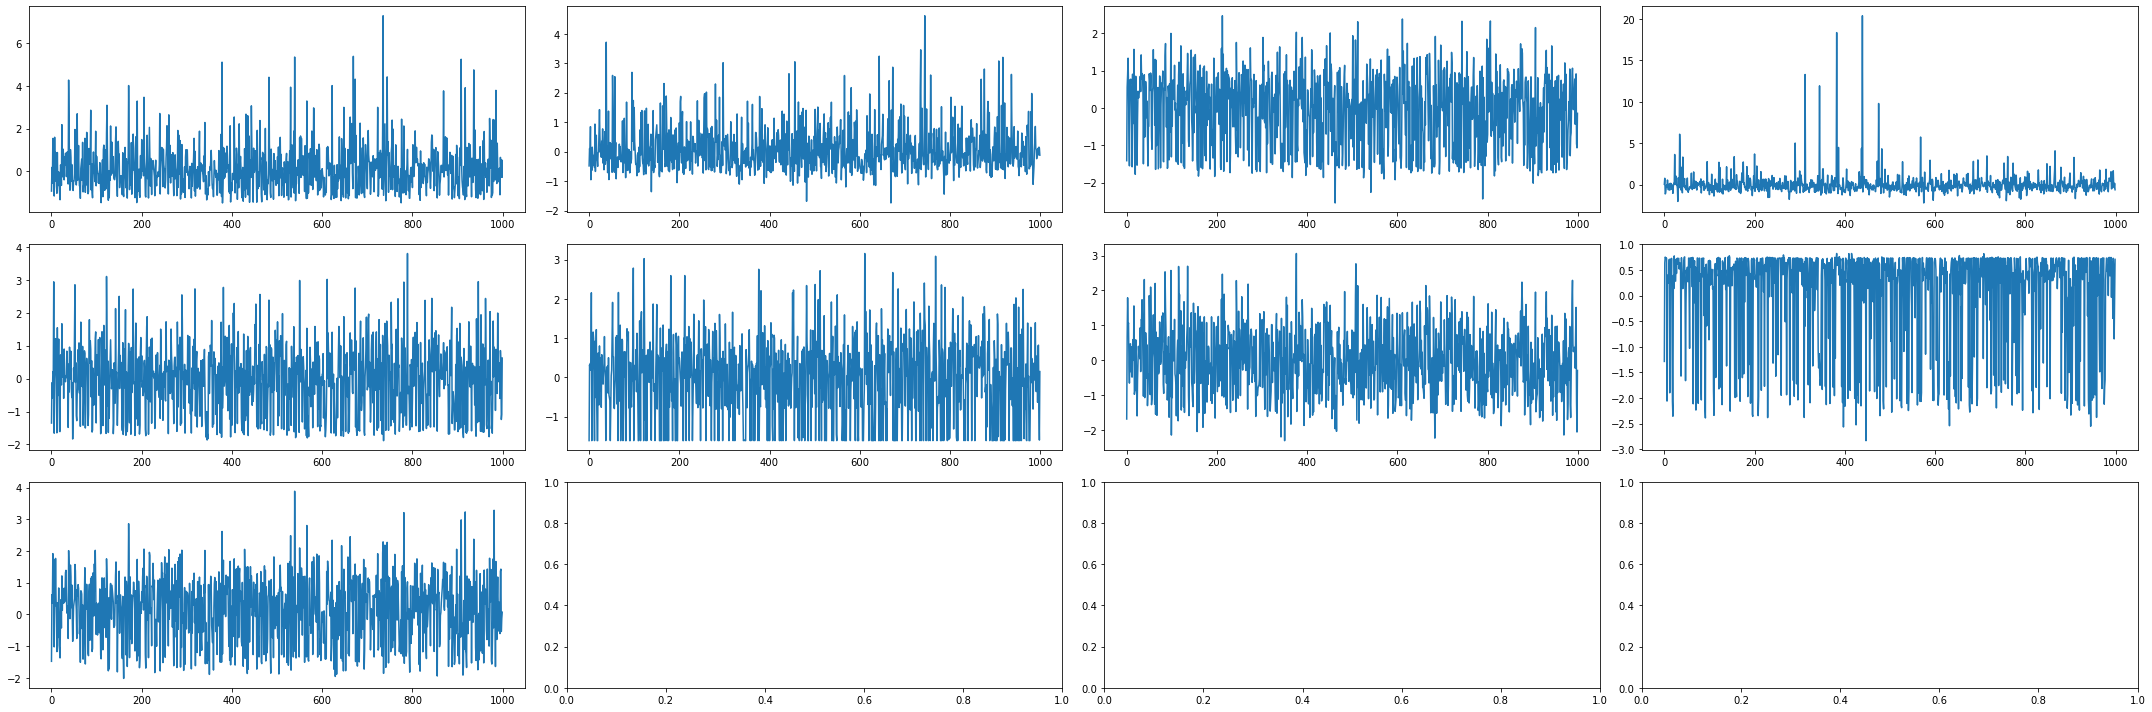

In [15]:
local_ploter(X_train_samples)

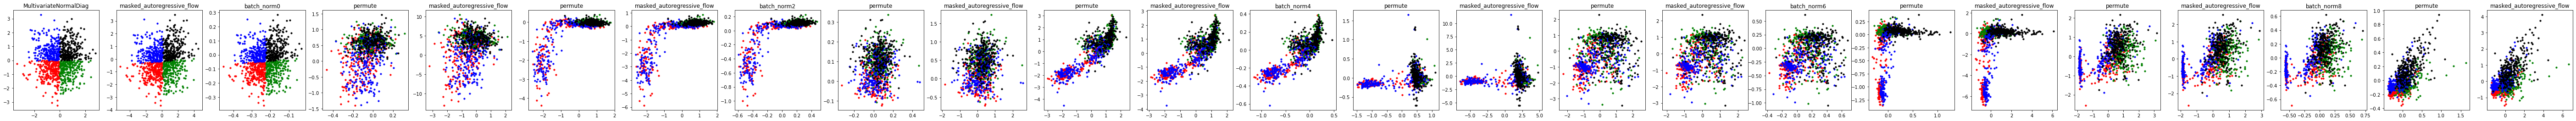

In [16]:
temp = base_dist.sample(1000)
samples = [temp]
names = [base_dist.name]
for bj in model.flow.bijector.bijectors[::-1]:
    temp = bj.forward(temp)
    samples.append(temp)
    names.append(bj.name)

f, arr = plt.subplots(1, len(samples), figsize=(4 * (len(samples)), 4))
X0 = samples[0].numpy()
for i in range(len(samples)):
    X1 = samples[i].numpy()
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green')
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue')
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black')
    # arr[i].set_xlim([-2, 2])
    # arr[i].set_ylim([-2, 2])
    arr[i].set_title(names[i])

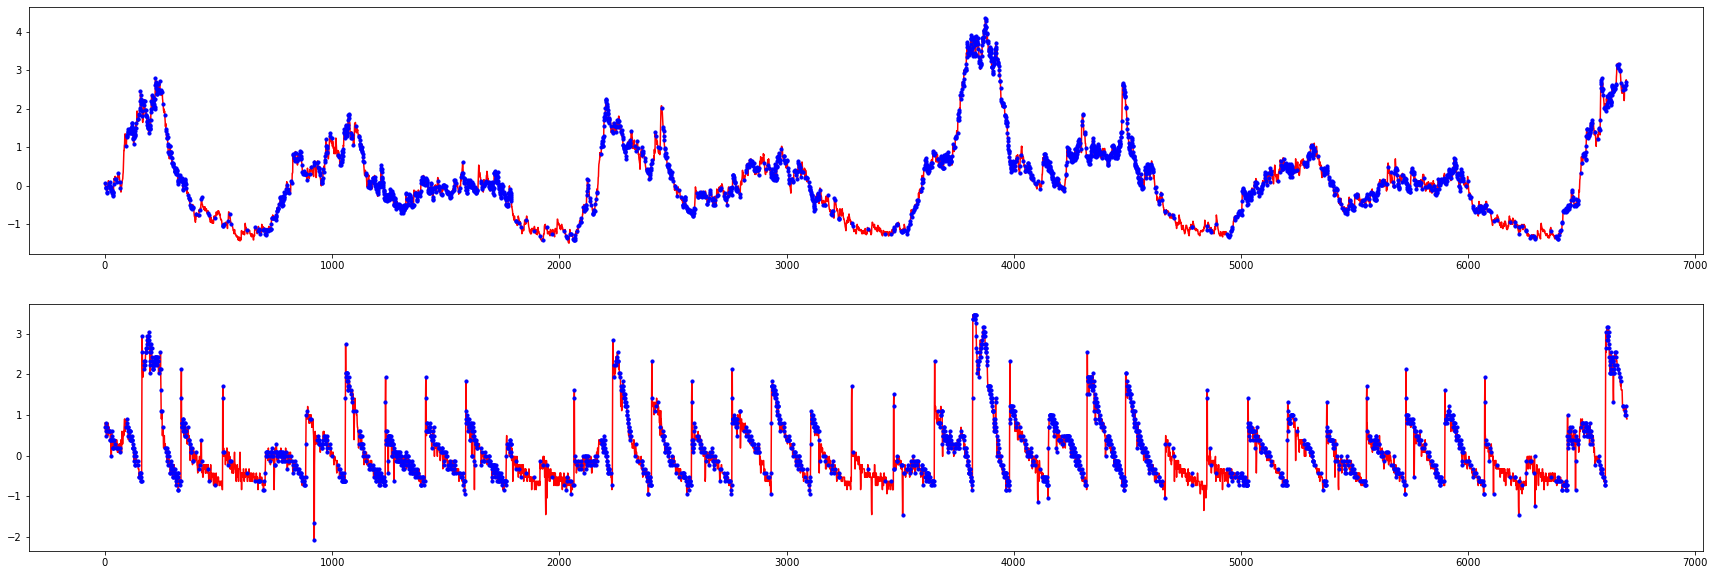

In [17]:
# TODO: how to determin the threshold?
anomalies = detect_anomalies(data=X_train, model=model.flow, threshold=0.01)
fig, axes = plt.subplots(2, figsize=(30,10))
x = np.arange(X_train.shape[0])
axes[0].plot(x, X_train[:, 0], color='red', zorder=0)
axes[0].scatter(anomalies, X_train[anomalies, 0], s=10, color='blue', zorder=1)

axes[1].plot(x, X_train[:, 1], color='red', zorder=0)
axes[1].scatter(anomalies, X_train[anomalies, 1], color='blue', s=10, zorder=1)

plt.show()

# Data Distribution Before/After Training

In [18]:
temp = model.flow.bijector.inverse(X_train).numpy()

## Before

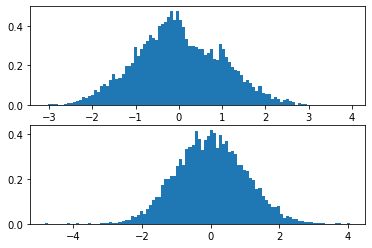

In [19]:
fig, axes = plt.subplots(2)
axes[0].hist(temp[:, 0], bins=100, density=True)
axes[1].hist(temp[:, 1], bins=100, density=True)
plt.show()

## After

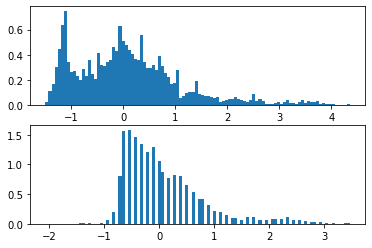

In [20]:
fig, axes = plt.subplots(2)
axes[0].hist(X_train[:, 0], bins=100, density=True)
axes[1].hist(X_train[:, 1], bins=100, density=True)
plt.show()

# Generate Data for the Classifier

In [21]:
factor = 2
anomalies = sample_anomalies(model.flow, factor=factor, n_samples=3000, sample_shape=input_dims)
normals = sample_normals(model.flow, factor=factor, n_samples=10000, sample_shape=input_dims)

In [22]:
anomalies = pd.DataFrame(anomalies)
normals = pd.DataFrame(normals)
anomalies.columns = ['v%d' % i for i in range(input_dims)]
normals.columns = ['v%d' % i for i in range(input_dims)]
anomalies['label'] = 1
normals['label'] = 0

In [23]:
clr_data = pd.concat([anomalies, normals], axis=0)
clr_data = clr_data.dropna()
clr_data = shuffle(clr_data)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(clr_data[clr_data.columns[:-1]], clr_data['label'], test_size=0.33, random_state=42)
clf, score = clfr.RFClassifier(X_train, y_train, X_test, y_test)
print('precision: {}'.format(score[0]))
print('recall: {}'.format(score[1]))
print('fscore: {}'.format(score[2]))
print('support: {}'.format(score[3]))

precision: [1. 1.]
recall: [1. 1.]
fscore: [1. 1.]
support: [3298  992]


# Apply Classifier on Real Data

In [25]:
y_data = clf.predict(X_train)
y_data_anomalies = np.where(y_data == 1)

In [26]:
X_train = X_train.values

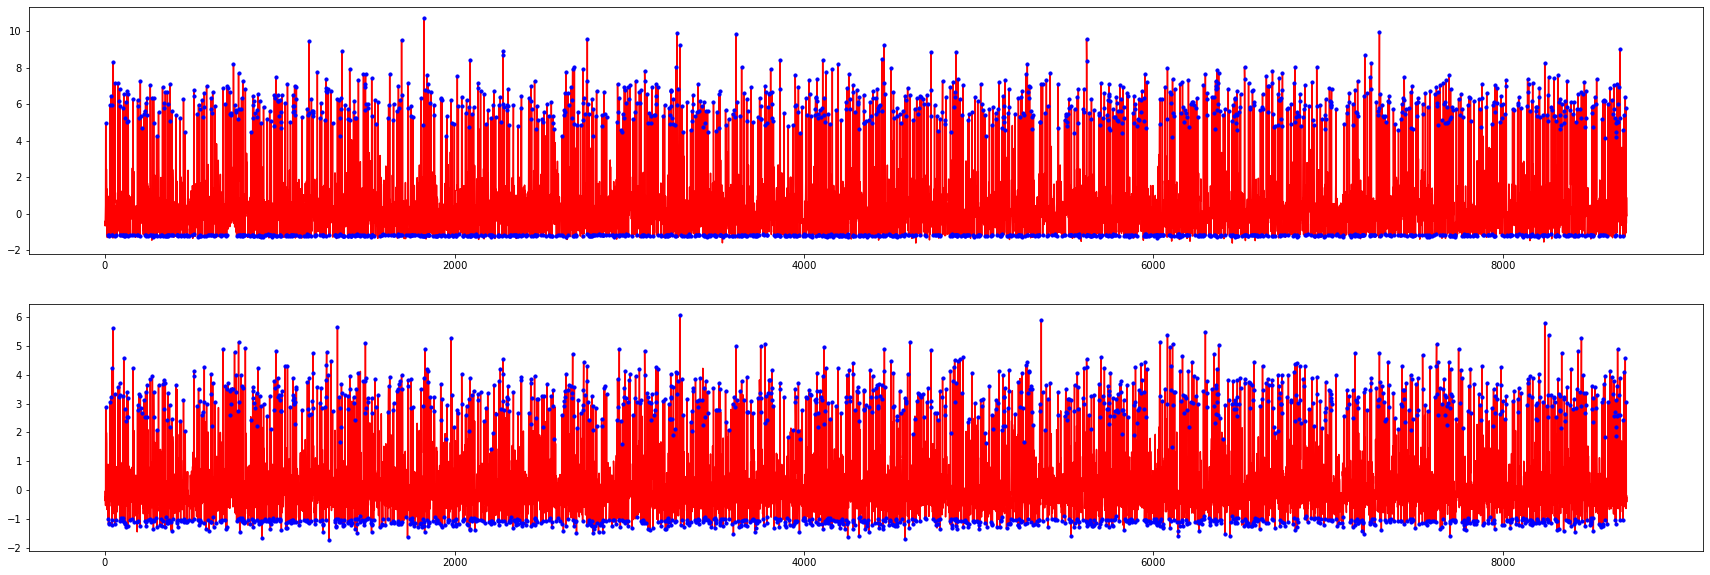

In [27]:
fig, axes = plt.subplots(2, figsize=(30,10))
x = np.arange(len(X_train[:, 0]))
axes[0].plot(x, X_train[:, 0], color='red', zorder=0)
axes[0].scatter(y_data_anomalies, X_train[y_data_anomalies, 0], s=10, color='blue', zorder=1)

axes[1].plot(x, X_train[:, 1], color='red', zorder=0)
axes[1].scatter(y_data_anomalies, X_train[y_data_anomalies, 1], color='blue', s=10, zorder=1)

plt.show()